In [25]:
# Importamos librerías
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
from re import sub 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (8, 6), 'figure.dpi': 120})
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [66]:
url = 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-1'

list_pages = []
for i in range(1,20):
    url_list = url.replace("1", str(i)) 
    list_pages.append(url_list)
    #print(url_list)
list_pages

['https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-1',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-2',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-3',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-4',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-5',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-6',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-7',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-8',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-9',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-10',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-11',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-12',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-13',
 'https://www.argenprop.com/inmuebles-venta-pais-argentina-pagina-14',
 'https://www.a

In [67]:
def conjunto_pages(list_pages):
    urls = []
    for url in list_pages:
        # Extraemos las URLs
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        # Pedimos las etiquetas que contengan las URLs
        links = soup.find_all('a')

        for link in links:
            if link.get('href')[0:5]=="/depa" or link.get('href')[0:5]=="/casa":
                urls.append('https://www.argenprop.com' + link.get('href'))
    return urls     
total_pages = conjunto_pages(list_pages)
print(len(total_pages))

380


In [4]:
total_pages[0]

'https://www.argenprop.com/departamento-en-venta-en-palermo-hollywood-3-ambientes--7337778'

In [68]:
def valor_numerico (regEx, text):
    lista_resultados = re.findall(regEx, text)
    if len(lista_resultados) == 1:
        resultado = lista_resultados[0]
    else:
        resultado = 0        
    return resultado    

def extraccion (url):
    matches = []
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    datos_inmueble = soup.find_all('div', {'class':'desktop'})

    if soup.find('li', {'title':'Sup. cubierta'}):
        metros_cubiertos_html = soup.find('li', {'title':'Sup. cubierta'})
        metros_cubiertos = valor_numerico("([0-9]+)\s" ,metros_cubiertos_html.find('div', {'class':'desktop'}).text)
    else:
        metros_cubiertos = 0
    matches.append(metros_cubiertos)

    if soup.find('li', {'title':'Dormitorios'}):
        dormitorios_html = soup.find('li', {'title':'Dormitorios'})
        dormitorios = valor_numerico("([0-9]+)\s" ,dormitorios_html.find('div', {'class':'desktop'}).text)
    else:
        dormitorios = 0
    matches.append(dormitorios)

    if soup.find('li', {'title':'Antiguedad'}):
        antiguedad_html = soup.find('li', {'title':'Antiguedad'})
        antiguedad = valor_numerico("([0-9]+)\s" , antiguedad_html.find('div', {'class':'desktop'}).text)
    else:
        antiguedad = 0
    matches.append(antiguedad)
    
    if soup.find('li', {'title':'Ba&#xF1;os'}):
        banios_html = soup.find('li', {'title':'Ba&#xF1;os'})
        banios = valor_numerico("([0-9]+)\s" ,banios_html.find('div', {'class':'desktop'}).text)
    else:
        banios = 0
    matches.append(banios)

    if soup.find('li', {'title':'Ambientes'}):
        ambientes_html = soup.find('li', {'title':'Ambientes'})
        ambientes = valor_numerico("([0-9]+)\s" ,ambientes_html.find('div', {'class':'desktop'}).text)
    else:
        ambientes = 0
    matches.append(ambientes)
# "(.?)\s*d" 
    datos = soup.find('input', {'id':'ga-dimension-ficha'})

    if datos['data-barrio']:
        matches.append(datos['data-barrio'])
    else:
        matches.append(0)

    if datos['data-moneda']:
        matches.append(datos['data-moneda'])
    else:
        matches.append('USD')

    if datos['data-price']:
        matches.append(datos['data-price'])
    else:
        matches.append(0)

    return matches      
extraccion(total_pages[10])  

['140', '3', '8', 0, '4', 'Belgrano', 'USD', '445000']

In [69]:
df = pd.DataFrame(columns=['metros_cubiertos', 'dormitorios', 'antiguedad','banios', 'ambientes', 'barrio', 'moneda', 'precio'])    

for link in total_pages:
    lista = extraccion(link) 
    #print(len(lista))
    df.loc[len(df)] = lista 
df.head(2)    

,metros_cubiertos,dormitorios,antiguedad,banios,ambientes,barrio,moneda,precio
0,115,2,14,0,3,Palermo,USD,320000
1,290,3,40,0,4,Palermo,USD,395000


In [63]:
len(df)

200

In [72]:
df.dtypes

metros_cubiertos    object
dormitorios         object
antiguedad          object
banios              object
ambientes           object
barrio              object
moneda              object
precio              object
dtype: object

In [61]:
df2 = df.drop(['barrio', 'moneda', 'banios'], axis=1)
df2 = df2.astype(float)
df2.head(2)

,metros_cubiertos,dormitorios,antiguedad,ambientes,precio
0,115.0,2.0,14.0,3.0,320000.0
1,290.0,3.0,40.0,4.0,395000.0


<AxesSubplot:>

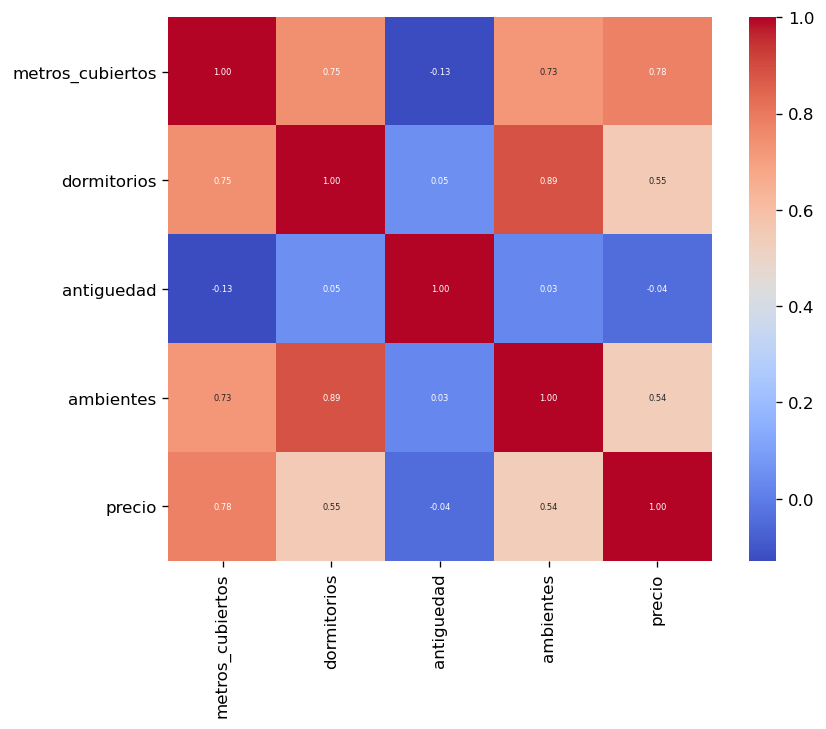

In [62]:
corr = df2.corr()
sns.heatmap(corr, cbar = True, square = True, annot = True, fmt = '.2f', annot_kws = {'size': 5}, cmap = 'coolwarm')

In [48]:
# Aplicando el modelo de regresión 
# Seleccionamos las variables predictoras
X = df[["metros_cubiertos", "dormitorios", 'antiguedad', "ambientes"]] 
# Defino el Target
y = df.precio
# Separo en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Generamos el Modelo de Regresión Lineal
linear_model = LinearRegression()
# Fiteo el modelo
linear_model.fit(X_train, y_train)

LinearRegression()

In [73]:
#Evaluamos el modelo
for i, model in enumerate ([linear_model]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict (X_test)

    #print(f'Modelo benchmark: {modelo[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    #print(f'Raiz del error cuadratico medio en train: {rmse_train}')
    #print(f'Raiz del error cuadratico medio en test: {rmse_test}')

new_data = pd.DataFrame({'metros_cubiertos': [100],"dormitorios":[1], 'antiguedad': [2], 'ambientes': [3]})
prediction = model.predict(new_data)
print("Predicción del precio del inmueble:", prediction[0])

Predicción del precio del inmueble: 196945.15580074303


In [60]:
dato_filtrado = df2[(df2.metros_cubiertos <= 100) & (df2.dormitorios <= 2) & (df2.antiguedad <=2) & (df2.ambientes <=2)]
dato_filtrado

,metros_cubiertos,dormitorios,antiguedad,banios,ambientes,precio
5,45.0,0.0,0.0,0.0,1.0,113000.0
34,39.0,0.0,1.0,0.0,1.0,144700.0
36,32.0,0.0,0.0,0.0,1.0,87000.0
38,49.0,1.0,1.0,0.0,2.0,156000.0
39,66.0,1.0,1.0,0.0,2.0,165000.0
57,46.0,1.0,0.0,0.0,2.0,126000.0
59,48.0,1.0,0.0,0.0,2.0,147999.0
60,39.0,1.0,0.0,0.0,2.0,124999.0
67,32.0,0.0,0.0,0.0,1.0,80000.0
68,49.0,1.0,0.0,0.0,2.0,163999.0
